In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
from lib import models, graph, coarsening
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from data_utils import *

In [4]:
from scipy import sparse

In [12]:
brain_regions = np.genfromtxt('/Users/linggeli/Desktop/brain_regions.csv', dtype=int, delimiter=',')[:40]
p_values = np.genfromtxt('/Users/linggeli/Desktop/p_values.csv', delimiter=',')[:40]

In [13]:
print(brain_regions)
print(brain_regions.shape)
print(p_values)
print(p_values.shape)

[ 10  11  19  32  37  38  39  45  46  51  57  58  69  87  88  97  98  99
 100 101 104 106 132 136 139 142 204 211 240 241 251 252 262 263 264 265
 271 298 299 304]
(40,)
[1.240796e-02 6.908696e-01 1.518664e-01 1.993193e-01 1.856546e-06
 2.531630e-07 6.086602e-03 3.806705e-04 1.357438e-03 1.197736e-26
 5.270106e-04 5.450616e-01 1.518743e-01 4.494447e-37 9.772724e-25
 2.428856e-43 1.288293e-42 1.541979e-22 2.469779e-45 6.897775e-01
 3.857627e-01 2.848500e-24 1.733762e-28 1.713287e-33 5.042079e-53
 5.498933e-01 2.606756e-01 4.687121e-25 2.782816e-06 8.266154e-01
 1.471002e-25 4.662759e-31 3.688270e-23 2.982207e-36 4.826068e-46
 3.367004e-37 4.493694e-24 1.900653e-22 2.987089e-33 2.772477e-01]
(40,)


In [14]:
time_series_dir = '/Users/linggeli/cnn_graph/data/time_series/cup/'
behavioral_dir = '/Users/linggeli/cnn_graph/data/fMRIbehav/cup/'
subject_id_list = get_subject_id(time_series_dir)
N_COEF = 5
X = get_all_features(time_series_dir, behavioral_dir, subject_id_list, 
                        n_time=64, coef_idx=range(N_COEF))[:, brain_regions, :]
y = get_all_labels(behavioral_dir, subject_id_list) - 1

  0%|          | 0/209 [00:00<?, ?it/s]//anaconda/envs/graphcnn/lib/python3.5/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)
100%|██████████| 209/209 [00:42<00:00,  1.44it/s]


In [19]:
def spatial_distance_graph(adj_matrix_path, pct):
    """
    Graph based on spatial distance between brain regions.

    :param adj_matrix_path: (string) path to already calculated csv file
    :param pct: (float) percentage between 0 and 100 to make the graph sparse
    :return: (2d numpy array) of size [100, 100] graph adjacency matrix
    """
    adj_matrix = np.genfromtxt(adj_matrix_path, delimiter=',')
    adj_matrix[np.isnan(adj_matrix)] = 0
    thres = np.percentile(adj_matrix, pct)
    A_spatial = adj_matrix[brain_regions, :][:, brain_regions]
    A_spatial[A_spatial < thres] = 0
    return A_spatial

In [105]:
adj_matrix_path = '/Users/linggeli/cnn_graph/stuff/adj_matrix.csv'
A_spatial = spatial_distance_graph(adj_matrix_path, 80)

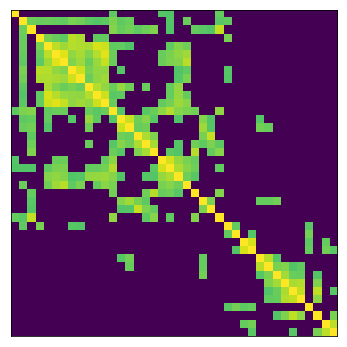

In [106]:
plt.figure(figsize=(6, 6))
plt.imshow(A_spatial)
plt.xticks([])
plt.yticks([])
plt.show()

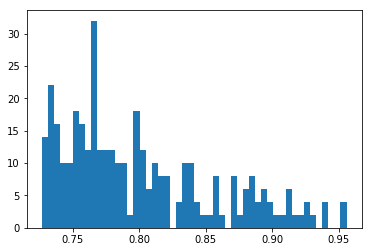

0.91298614901129
0.8895717351266831
0.8559577506613115


In [109]:
edges = A_spatial[(A_spatial < 1) & (A_spatial > 0)].flatten()
plt.hist(edges, bins=50)
plt.show()
print(np.percentile(edges, 95))
print(np.percentile(edges, 90))
print(np.percentile(edges, 80))

In [110]:
total_edges = np.sum((A_spatial < 1) & (A_spatial > 0))
select = (A_spatial < 1) & (A_spatial > 0.855957)
A_spatial_mask = A_spatial.copy()
A_spatial_mask[select] = 0
print(np.sum(select) / total_edges)

0.20105820105820105


In [111]:
def random_graph(random_seed, pct):
    """
    Graph that is randomly generated.

    :param random_seed: (int) seed for randomness
    :param pct: (float) percentage between 0 and 100 to make the graph sparse
    :return: (2d numpy array) of size [100, 100] graph adjacency matrix
    """
    np.random.seed(random_seed)
    A_random = np.random.uniform(low=0, high=1, size=(40, 40))
    thres = 1 - 0.01 * pct
    A_random[A_random > thres] = 0
    A_random = A_random / thres
    np.fill_diagonal(A_random, 1)
    return A_random

In [129]:
A_random = random_graph(0, 80)

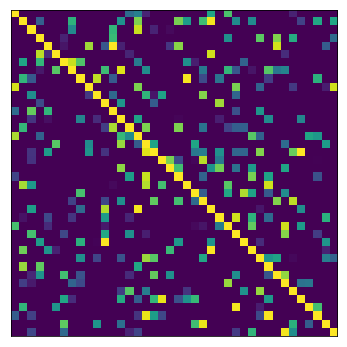

In [130]:
plt.figure(figsize=(6, 6))
plt.imshow(A_random)
plt.xticks([])
plt.yticks([])
plt.show()

In [50]:
from scipy.stats import pearsonr
from tqdm import tqdm

In [51]:
def pearson_correlation_graph(time_series_dir, pct):
    """
    Graph based on Pearson correlation between time series.

    :param time_series_dir: (string) directory of time series
    :param pct: (float) percentage between 0 and 100 to make the graph sparse
    :return: (2d numpy array) of size [100, 100] graph adjacency matrix
    """
    subject_id_list = get_subject_id(time_series_dir)
    n = len(subject_id_list)
    all_pearson = np.zeros((n, 40, 40))
    for i, subject_id in enumerate(tqdm(subject_id_list)):
        time_series_data = load_time_series(time_series_dir, subject_id)[brain_regions, :]
        time_series_data = preprocess_time_series(time_series_data)
        for j in range(40):
            for k in range(j, 40):
                all_pearson[i, j, k] = pearsonr(time_series_data[j, :], time_series_data[k, :])[0]
                all_pearson[i, k, j] = all_pearson[i, j, k]
    mean_pearson = np.mean(all_pearson, axis=0)
    thres = np.percentile(mean_pearson, pct)
    A_pearson = mean_pearson
    A_pearson[A_pearson < thres] = 0
    return A_pearson

In [91]:
A_pearson = pearson_correlation_graph(time_series_dir, 80)

100%|██████████| 209/209 [00:18<00:00, 11.21it/s]


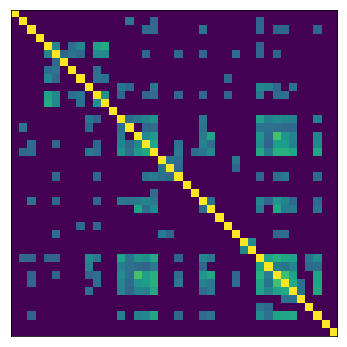

In [92]:
plt.figure(figsize=(6, 6))
plt.imshow(A_pearson)
plt.xticks([])
plt.yticks([])
plt.show()

In [156]:
def remove_connections(A_matrix, p_values, k):
    top_regions = p_values.argsort()[:k]
    for r in top_regions:
        A_matrix[r, :] = 0
        A_matrix[:, r] = 0
    np.fill_diagonal(A_matrix, 1)
    return A_matrix

In [161]:
A_spatial_mask = remove_connections(A_spatial, p_values, 10)

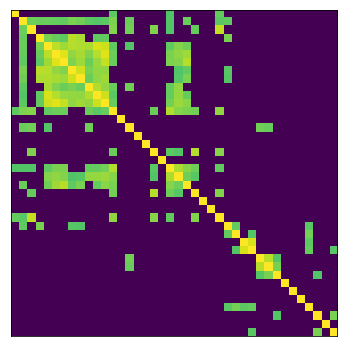

In [162]:
plt.figure(figsize=(6, 6))
plt.imshow(A_spatial_mask)
plt.xticks([])
plt.yticks([])
plt.show()

**Test different graphs**

In [132]:
n_train = 600
n_val =  200

np.random.seed(0)
indices = np.random.permutation(X.shape[0])

X_train = X[indices[:n_train]]
X_val   = X[indices[n_train:n_train+n_val]]

y_train = y[indices[:n_train]]
y_val   = y[indices[n_train:n_train+n_val]]

X_train = (X_train - np.mean(X)) / np.std(X)
X_val = (X_val - np.mean(X)) / np.std(X)

In [163]:
A = sparse.csr_matrix(A_spatial_mask).astype(np.float32)

In [164]:
graphs, perm = coarsening.coarsen(A, levels=2, self_connections=False)

Layer 0: M_0 = |V| = 72 nodes (32 added),|E| = 124 edges
Layer 1: M_1 = |V| = 36 nodes (10 added),|E| = 47 edges
Layer 2: M_2 = |V| = 18 nodes (0 added),|E| = 16 edges


In [165]:
L = [graph.laplacian(A, normalized=True) for A in graphs]

In [166]:
X_train_list = []
X_val_list = []
for i in range(N_COEF):
    X_train_list.append(coarsening.perm_data(X_train[:, :, i], perm))
    X_val_list.append(coarsening.perm_data(X_val[:, :, i], perm))

X_train_perm = np.stack(X_train_list, axis=-1)
X_val_perm = np.stack(X_val_list, axis=-1)

In [167]:
from fmri.graph_models import multi_cgcnn

In [168]:
N_FILTER = 30
DENSE_SIZE = 20

In [169]:
params = dict()
params['dir_name']       = 'demo'
params['num_epochs']     = 50
params['batch_size']     = 20
params['eval_frequency'] = 100

# Building blocks.
params['filter']         = 'chebyshev5'
params['brelu']          = 'b1relu'
params['pool']           = 'apool1'

# Number of classes.
C = 2
#C = y.max() + 1
#assert C == np.unique(y).size

# Architecture.
params['F']              = [N_FILTER, N_FILTER]  # Number of graph convolutional filters.
params['K']              = [10, 10]  # Polynomial orders.
params['p']              = [2, 2]    # Pooling sizes.
params['M']              = [DENSE_SIZE, C]  # Output dimensionality of fully connected layers.

# Optimization.
params['regularization'] = 5e-4
params['dropout']        = 0.9
params['learning_rate']  = 1e-3
params['decay_rate']     = 0.95
params['momentum']       = 0.9
params['decay_steps']    = n_train / params['batch_size']

params['n_graph'] = N_COEF

In [170]:
model = multi_cgcnn(L, **params)

NN architecture
  input: M_0 = 72
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 72 * 30 / 2 = 1080
    weights: F_0 * F_1 * K_1 = 1 * 30 * 10 = 300
    biases: F_1 = 30
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 36 * 30 / 2 = 540
    weights: F_1 * F_2 * K_2 = 30 * 30 * 10 = 9000
    biases: F_2 = 30
  layer 3: fc1
    representation: M_3 = 20
    weights: M_2 * M_3 = 540 * 20 = 10800
    biases: M_3 = 20
  layer 4: logits (softmax)
    representation: M_4 = 2
    weights: M_3 * M_4 = 20 * 2 = 40
    biases: M_4 = 2


In [171]:
accuracy, loss, t_step = model.fit(X_train_perm, y_train, X_val_perm, y_val)

step 100 / 1500 (epoch 3.33 / 50):
  learning_rate = 8.57e-04, loss_average = 7.21e-01
  validation accuracy: 63.00 (126 / 200), f1 (weighted): 62.67, loss: 7.59e-01
  time: 24s (wall 9s)
step 200 / 1500 (epoch 6.67 / 50):
  learning_rate = 7.35e-04, loss_average = 6.86e-01
  validation accuracy: 64.00 (128 / 200), f1 (weighted): 63.61, loss: 7.56e-01
  time: 46s (wall 17s)
step 300 / 1500 (epoch 10.00 / 50):
  learning_rate = 6.30e-04, loss_average = 6.87e-01
  validation accuracy: 63.00 (126 / 200), f1 (weighted): 62.90, loss: 7.58e-01
  time: 67s (wall 23s)
step 400 / 1500 (epoch 13.33 / 50):
  learning_rate = 5.13e-04, loss_average = 6.96e-01
  validation accuracy: 63.50 (127 / 200), f1 (weighted): 63.21, loss: 7.56e-01
  time: 89s (wall 29s)
step 500 / 1500 (epoch 16.67 / 50):
  learning_rate = 4.40e-04, loss_average = 6.54e-01
  validation accuracy: 64.50 (129 / 200), f1 (weighted): 64.28, loss: 7.54e-01
  time: 110s (wall 35s)
step 600 / 1500 (epoch 20.00 / 50):
  learning_rate 